# GOEMod: Groundwater outcrop erosion model

A simple model of groundwater flow, overland flow and erosion in 2D, with parallel streams.

Named after the groundwater outcrop erosion model, as first conceptualized by de Vries (1974, 1976)

Step by step version, with figures generated to illustrate the different steps in the iterative model workflow.

# Introduction

## import modules:

In [227]:
import string
import itertools
import datetime
import numpy as np
import matplotlib.pyplot as pl

pl.rcParams['mathtext.default'] = 'regular'

## Set up model parameters

In [228]:
hour = 60.0 * 60.0
day = 24.0 * hour
year = 365.25 * day
kyr = 1e3 * year

# timestep
dt = 1.0 * year

#n_timesteps = 1000
total_runtime = 1e5 * year

# dimensions of model domain in x direction, perpendicular to streams
width = 10000

#
dx = 5.0

#
fixed_upstream_length = True

# upstream length: length of contributing area to streams, upstream from the modeled 2D cross section
upstream_length = width / 2.0
downstream_length = width / 2.0

# initial relief
initial_relief = 0.25
n_initial_topo_segments = 200

#
#max_z_change_limit = 0.1

# aspect ratio to calculate size of each sub-catchment in the 3rd dimension
# aspect ratio of 2.0 means that the upstream contributing length 
# is 2x the length of the contributing area
# in the model domain / cross-section
upstream_aspect_ratio = 10.0

# precipitation (=precip - evapotranspiration)
P = 0.75 / year

#
precip_return_time = 1.0 * year

precipitation_duration = 3.0 * hour


# evapotranspiration
ET = 0.375 / year

# overland flow vs recharge parameters
phi = 0.20
specific_yield = 0.20

# average recharge or calculate spatially distributed values
average_rch = True

# transmissivity (m2/sec)
T = 1e-2

# erosion parameters:
#rho_s = 2650.0
k_f = 1.0
k_t = 0.011
m = 1.8
n = 2.1
K_n = 25.0
S_init = S = 5e-3

# hillslope diffusion
# value from Tucker & Bras (1998)
K_d = 1e-2 / year

# parameters relating channel width and discharge
k_w = 3.65
omega = 0.5

# slope of stream bed perpendicular to flow direction
St = 0.05

# max. relative relief change in one timestep. expressed as fraction of total relief
max_rel_dz = 0.01

# min relative relief change in one timestep.
min_rel_dz = 0.005

#
closed_gw_basin = True

In [229]:
# precipitation excess
rch_init = P - ET

## Some figure parameters

In [230]:
xlabel = 'Distance (m)'
ylabel = 'Elevation (m)'

cmap = pl.get_cmap('tab20')

land_surf_color = cmap(10.0 * 1/20.)
watertable_color = cmap(0.0 * 1/20.)

past_surf_color = cmap(11.0 * 1/20.)
past_wt_color = cmap(1.0 * 1/20.)
init_surf_color = cmap(11.0 * 1/20.)
init_wt_color = cmap(1.0 * 1/20.)

col_overland = cmap(18.0 * 1/20.)
col_baseflow = cmap(8.0 * 1/20.)
col_hillslope = cmap(3.0 * 1/20.)

seepage_col = col_overland
stream_col = col_baseflow

## Calculate effective recharge

ie. recharge minus groundwater flow that is parallel to the streams (out out of the cross-section)

In [231]:
if closed_gw_basin is True:

    # gw flow leaving the model domain (m3/sec)
    gw_flow_out = T * S * width

    #
    rch_vol = rch_init * width * upstream_length

    #
    net_rch = rch_vol - gw_flow_out
    rch = net_rch / (width * upstream_length)

    print('gw flow out of the model domain = %0.2e m3/yr' % (gw_flow_out * year))
    print('total rch volume in model domain = %0.2e m3/yr' % (rch_vol * year))
    print('original rch in model domain = %0.2e m/yr' % (rch_init * year))
    print('net rch in model domain = %0.2e m/yr' % (rch * year))

    if rch <= 0:
        msg = 'error, negative effective recharge. Reduce transmissivity of stream slope to' \
        'limit the amount of groundwater flowing directly out of the model domain'
        raise ValueError(msg)
else:
    rch = rch_init

gw flow out of the model domain = 1.58e+07 m3/yr
total rch volume in model domain = 1.88e+07 m3/yr
original rch in model domain = 3.75e-01 m/yr
net rch in model domain = 5.94e-02 m/yr


## Generate an id number for this particular model run

This is useful to keep track of output datasets and figures

In [232]:
model_id = int(np.random.rand(1) * 1000)

today = datetime.datetime.now()
today_str = '%i-%i-%i' % (today.day, today.month, today.year)

output_file_adj = 'id_%i_%s' % (model_id, today_str)

print('appending this to each figure and output dataset filename: ', output_file_adj)

appending this to each figure and output dataset filename:  id_369_2-4-2021


## Set up grid:

In [233]:
nx = int(width / dx)

x = np.linspace(0, width, nx)

xc = (x[1:] + x[:-1]) / 2.0

# calculate width of cells
dxc = np.diff(x)

# calculate width between nodes
dxn = np.zeros_like(x)
dxn[1:] += dxc / 2.0
dxn[:-1] += dxc / 2.0

## Generate initial topography

In [234]:
print('generating initial topography with max relief of %0.2f m and %i linear segments' 
      % (initial_relief, n_initial_topo_segments))

init_z = 0.0

xx = np.linspace(0, nx*dx, n_initial_topo_segments)

z_depressions = (np.random.random(n_initial_topo_segments) - 0.5) * initial_relief + init_z
#z_depressions = np.random.randn(n_z_perturbations) * relief / 2.0 + init_z

z_init = np.interp(x, xx, z_depressions)

z = z_init.copy()

generating initial topography with max relief of 0.25 m and 200 linear segments


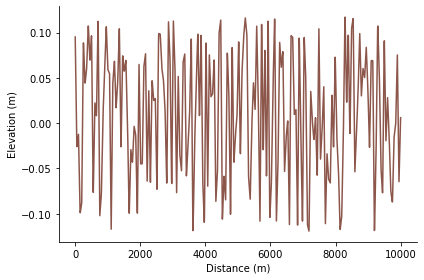

In [235]:
fig, ax = pl.subplots(1, 1)
ax.plot(x, z_init, color=land_surf_color)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('fig/initial_topography_%s.pdf' % output_file_adj)

**Fig caption** *Randomly generated initial topography*

## Analytical solution groundwater level

The model uses an anlytical solution for steady-state groundwater flow. The solution follows the Dupuit-Forchheimer equation:

$$\Delta h = \dfrac{R}{T} x (L - x) + \Delta H x / L$$

where h is hydraulic head (m), R is recharge ($m s^{-1}$), T is transmissivity ($m^2\; s^{-1}$), L is the distance between two streams (m) and x is the distance to the first stream and $\Delta H$ is the difference in water level between the two streams.

analytical solution of groundwater flow equation

uses analytical solution to 1D gw flow in an aquifer with constant recharge and homogenous transmissivity to a fully penetrating channel

equation solved piecewise between each channel

starts with 1 fixed head (seepage location/stream) at lowest elevation, subsequently seepage nodes are added at lowest elevation point of nodes where watertable exceeds the surface. Iterative solution continued until $h < z$ everywhere (except in seepage nodes)


In [236]:
def analytical_solution_h_one_side(rch, T, L, x):
    dh = rch / T * (L * x - 0.5 * x**2)
    
    return dh

def analytical_solution_h(rch, T, L, x, dH):
    
    dh = 0.5 * rch/T * x * (L-x) + dH * x /L
    
    return dh
    

def calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs):

    """
    use analytcial solutions to calculate steady-state hydraulic head 

    """
    
    h = np.ones_like(x)

    q_gw_rch = [0] * len(seepage_pts)

    for xli, xl, hl, xri, xr, hr in zip(seepage_pts[:-1], seepage_xs[:-1], seepage_hs[:-1],
                                        seepage_pts[1:], seepage_xs[1:], seepage_hs[1:]):
        

        dH = hr -  hl
        L = xr - xl
        xloc = x[xli:xri] - x[xli]
        
        if type(rch) is np.float64 or type(rch) is float:
            rch_avg = rch
        else:
            rch_avg = rch[xli:xri].mean()
        
        hloc = analytical_solution_h(rch_avg, T, L, xloc, dH)
        h[xli:xri] = hloc + hl

    # add h for left-hand side
    if seepage_pts[0] > 0:
        xl = x[0]
        xli = 0
        xr = x[seepage_pts[0]]
        xri = seepage_pts[0]
        L = xr - xl
        xloc = L - x[xli:xri]
        
        if type(rch) is np.float64 or type(rch) is float:
            rch_avg = rch
        else:
            rch_avg = rch[xli:xri].mean()
            
        hloc = analytical_solution_h_one_side(rch_avg, T, L, xloc)
        h[xli:xri] = hloc + seepage_hs[0]

    # add h for right-hand side
    if seepage_pts[-1] < (len(x) - 1):
        xl = seepage_xs[-1]
        xli = seepage_pts[-1]
        xr = x[-1]
        xri = len(x)
        xloc = x[xli:xri] - x[xli]
        L = xr - xl
        
        if type(rch) is np.float64 or type(rch) is float:
            rch_avg = rch
        else:
            rch_avg = rch[xli:xri].mean()
            
        hloc = analytical_solution_h_one_side(rch_avg, T, L, xloc)
        h[xli:xri] = hloc + seepage_hs[-1]
    
    h[seepage_pts] = z[seepage_pts]
    
    return h

## Find streams/seepage pts

In [237]:
def find_next_seepage_pt(h, z, seepage_bool, seepage_pts):
    
    a = len(seepage_pts)
    
    zc = z.copy()

    # find lowest point in model domain where h > z
    zc[seepage_bool == True] = 99999
    zc[h < z] = 99999
    
    if len(seepage_pts) > 0:
        if len(seepage_pts) > 1:
            for sp1, sp2 in zip(seepage_pts[:-1], seepage_pts[1:]):
                
                if sp2 - sp1 > 1:
                    ind_zmin = sp1 + np.argmin(zc[sp1:sp2])
                    if zc[ind_zmin] != 99999:
                        seepage_pts.append(ind_zmin)
        
        if seepage_pts[0] > 0:
            ind_zmin = np.argmin(zc[:seepage_pts[0]])
            if zc[ind_zmin] != 99999:
                seepage_pts.append(ind_zmin)
        
        if seepage_pts[-1] < (len(x) - 1):
            ind_zmin = seepage_pts[-1] + np.argmin(zc[seepage_pts[-1]:])
            if zc[ind_zmin] != 99999:
                seepage_pts.append(ind_zmin)
    
    else:
        ind_zmin = np.argmin(zc)
        seepage_pts.append(ind_zmin)
    
    # remove duplicates
    seepage_pts = list(set(seepage_pts))
    
    # sort streams
    seepage_pts.sort()
    
    if len(seepage_pts) == a:
        print('warning, no improvement in seepage iterations')
        #print('seepage pts: ', seepage_pts)
        #raise ValueError
    
    return seepage_pts

In [238]:
# set initial h
h_init = z.min()
h = np.ones(z.shape) * h_init

seepage_pts = []
seepage_bool = np.full((len(x)), False)

seepage_pts = find_next_seepage_pt(h, z, seepage_bool, seepage_pts)
print(seepage_pts)

[1436]


## calculate h



In [239]:
seepage_xs =  x[seepage_pts]
seepage_hs = h[seepage_pts]

h = calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs)

In [240]:
def h_and_z_fig(ax, x, h, z, _color_pts, stream_pts, Q_stream, 
                stream_label='Q', stream_label_units=r'$m^2 a^{-1}$',
                add_legend=True, add_cb=True, cb_axs=None, remove_top_ax=True, cmap='viridis'):
    
    try:
        from cmcrameri import cm
        cmap2 = cm.batlow
    except:
        cmap2 = 'viridis'
        
    cmap = pl.get_cmap('tab20')

    land_surf_color = cmap(10.0 * 1/20.)
    watertable_color = cmap(0.0 * 1/20.)

    past_surf_color = cmap(11.0 * 1/20.)
    past_wt_color = cmap(1.0 * 1/20.)
    init_surf_color = cmap(11.0 * 1/20.)
    init_wt_color = cmap(1.0 * 1/20.)

    col_overland = cmap(18.0 * 1/20.)
    col_baseflow = cmap(8.0 * 1/20.)
    col_hillslope = cmap(3.0 * 1/20.)

    seepage_color = col_overland
    stream_color = col_baseflow

    #gr = (1 + np.sqrt(5)) / 2.0
    #fig, ax = pl.subplots(1, 1, figsize=(6, 6 / gr))
    
    ax.plot(x, z, color=land_surf_color, label='land surface')
    ax.plot(x, h, color=watertable_color, label='watertable')
    
    if seepage_pts is not None:
        ax.scatter(x[seepage_pts], z[seepage_pts], color=seepage_col, s=10, label='seepage')
    if stream_pts is not None:
        if Q_stream is None:
            ax.scatter(x[stream_pts], z[stream_pts], color=stream_color, marker='v', label='stream')
        else:
            sc = ax.scatter(x[stream_pts], z[stream_pts], c=Q_stream, 
                            marker='v', s=50, label='stream', zorder=100, cmap=cmap2)
            
            fig = pl.gcf()
            
            if add_cb is True:
                if cb_axs is None:
                    cb_axs = ax
                cb = fig.colorbar(sc, ax=cb_axs, shrink=0.5)
                cb.set_label(r'%s (%s)' % (stream_label, stream_label_units))
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if add_legend is True:
        ax.legend(frameon=False, bbox_to_anchor=[0.0, 1.02], loc='lower left', ncol=3)
    
    if remove_top_ax is True:
        ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

#fig = h_and_z_fig(x, h, z, seepage_pts, None, None)
#fig.savefig('fig/h_iteration_first_step_%s.pdf' % output_file_adj)

In [241]:
def remove_inflow_seepage_nodes(seepage_pts, x, h, T, inflow_lim):
    
    a = len(seepage_pts)
    
    
    # check if any seepage nodes cause inflow
    dh = np.diff(h)
    dxi = np.diff(x)
    q = -T * dh / dxi
    dq = q[1:] - q[:-1]
    #print(dq.min() * year, dq.max() * year

    dqn = np.zeros_like(z)
    dqn[1:-1] = dq
    rel_q = dqn / inflow_lim

    remove_seepage_nodes = np.where(rel_q > 1)[0]
    
    seepage_pts_mod = seepage_pts
    
    for s in seepage_pts_mod:
        if s in remove_seepage_nodes:
            #print('remove node %i from seepage list' %s)
            seepage_pts_mod.remove(s)
    ns = len(seepage_pts_mod)
    nr = ns - a
    #print('number of seepage pts remaining = %i' % ns)
    #print('%i nodes were removed because they generated more inflow than the recharge rate' % (a - ns))
    
    return seepage_pts_mod, nr

In [242]:
max_iter = len(x) * 3
#max_iter = 1
keep_going = True
h_converged = False

n_iter = 0

hs_int = []
seepage_pts_all = []

if type(rch) is float:
    inflow_lim = rch * dxn * 2
else:
    inflow_lim = rch.max() * dxn * 2
    
relief = z.max() - z.min()
max_h_error = 0.05 * relief
if max_h_error > 0.05:
    max_h_error = 0.05

while keep_going is True and n_iter < max_iter:
    
    seepage_pts_corr, nr = remove_inflow_seepage_nodes(seepage_pts, x, h, T, inflow_lim)
    
    #if nr < -1:
    seepage_pts = seepage_pts_corr
    seepage_xs =  x[seepage_pts]
    seepage_hs = z[seepage_pts]
    h = calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs)

    if len(seepage_pts) > 0:
        seepage_bool[np.array(seepage_pts)] = True
    seepage_pts = find_next_seepage_pt(h, z, seepage_bool, seepage_pts)
    
    seepage_xs =  x[seepage_pts]
    seepage_hs = z[seepage_pts]

    h = calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs)
        
    hs_int.append(h)
    
    seepage_pts_all.append(seepage_pts)
    
    # check if h is below the surface everywhere
    if np.any(h > z + max_h_error) == False:
        keep_going = False
        h_converged = True
    
    n_iter += 1

if h_converged is True:
    print('converged after %i iterations to %i seepage pts' % (n_iter, len(seepage_pts)))
else:
    print('convergence failed after %i iterations' % n_iter)

converged after 16 iterations to 24 seepage pts


-3


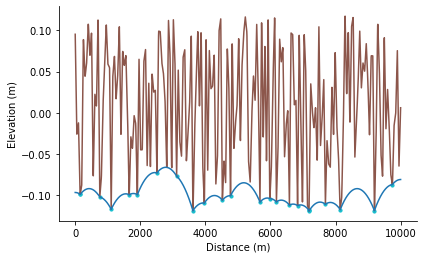

In [243]:
gr = (1 + np.sqrt(5)) / 2.0

fig, ax2 = pl.subplots(1, 1, figsize=(6, 6 / gr))

#ax = axs[0]
#ax2 = axs[1]
axs = [ax2]

for axi in axs:
    leg_surf, = axi.plot(x, z_init, color=land_surf_color)

if len(hs_int) > 5:    
    plot_int = -int(len(hs_int) / 5.0)
else:
    plot_int = -1
print(plot_int)
    
for hi, si in zip(hs_int[::plot_int], seepage_pts_all[::plot_int]):
    
    leg_int, = ax.plot(x, hi, ls=':')

for axi in axs:
    si = seepage_pts_all[-1]
    leg_final, = axi.plot(x, hs_int[-1], color=watertable_color)
    leg_seep = axi.scatter(x[si], z[si], s=10, marker='o', color=seepage_col)

#ax.set_ylim(z.min() * 1.25, z.max() * 1.25)

ax.legend([leg_surf, leg_int, leg_final, leg_seep], 
          ['surface', 'watertable iteration', 'final watertable', 'seepage location'], 
           bbox_to_anchor=(0.0, 1.03), loc='lower left', ncol=2)

ax2.set_xlabel(xlabel)
for axi in axs:
    axi.set_ylabel(ylabel)

for axi in axs:
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('fig/watertable_iteration_%s.pdf' % output_file_adj)

**Fig caption**: *Modeled steady-state groundwater level and location of groundwater seepage at  the start of the model run*

## Find active streams


In [244]:
def find_depressions(z):
    
    """
    Find depressions in a 1D array with elevation values 
    
    z : elevation
    
    
    returns
    z_depr : booelan array with True for depressions
    """
    
    
    ## find depressions
    dz = np.diff(z)
    z_depr = np.zeros_like(z, dtype=bool)
    potential_stream_pts = np.where(np.sign(dz[1:]) > np.sign(dz[:-1]) + 1)[0] + 1
    
    #ddz = np.diff(z, n=2)
    #potential_stream_pts = np.where(ddz > 0)[0] + 1 
    
    z_depr[potential_stream_pts] = True
    
    # add node on left-hand and right-hand sides
    if dz[0] > 0:
        z_depr[0] = True
    if dz[-1] < 0:
        z_depr[-1] = True
        
    return z_depr

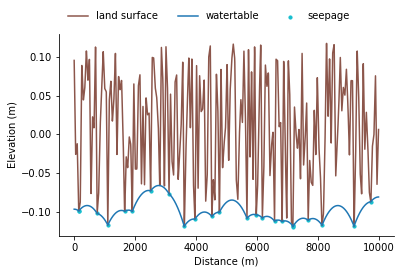

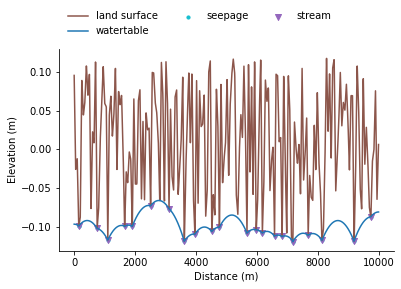

In [245]:
## find depressions
z_depr = find_depressions(z)

seepage_bool = np.zeros_like(z, dtype=bool)
seepage_bool[seepage_pts] = True

stream_pts_bf = np.where(np.logical_and(seepage_bool, z_depr))[0]
#stream_pts_bf = np.where(z_depr==True)[0]

gr = (1 + np.sqrt(5)) / 2.0
fig, ax = pl.subplots(1, 1, figsize=(6, 6 / gr))
ax = h_and_z_fig(ax, x, h, z, seepage_pts, None, None)

fig.savefig('fig/first_seepage_%s.pdf' % output_file_adj)
fig.savefig('fig/first_seepage_%s.png' % output_file_adj)

gr = (1 + np.sqrt(5)) / 2.0
fig2, ax2 = pl.subplots(1, 1, figsize=(6, 6 / gr))
ax2 = h_and_z_fig(ax2, x, h, z, None, stream_pts_bf, None)

fig2.savefig('fig/first_baseflow_streams_%s.pdf' % output_file_adj)
fig2.savefig('fig/first_baseflow_streams_%s.png' % output_file_adj)

## Calculate contributing area for baseflow to each stream

In [246]:
def calculate_contributing_area(x, u, stream_pts):

    """
    calculate the area contributing gw flow to each stream

    """


    contributing_area = np.zeros(len(stream_pts))
    contributing_area_pts = []
    for i, stream_pt in enumerate(stream_pts):
        if stream_pt == stream_pts[0]:
            contributing_area_left = x[stream_pt]
            contributing_area_pt1 = 0
        else:
            last_stream_pt = stream_pts[i-1]
            divide_loc = last_stream_pt + np.argmax(u[last_stream_pt:stream_pt])
            contributing_area_left = x[stream_pt] - x[divide_loc]
            contributing_area_pt1 = divide_loc
            
        if stream_pt == stream_pts[-1]:
            contributing_area_right = x.max() - x[stream_pt]
            contributing_area_pt2 = -1
        else:
            next_stream_pt = stream_pts[i+1]
            divide_loc = stream_pt + np.argmax(u[stream_pt:next_stream_pt])
            contributing_area_right = x[divide_loc] - x[stream_pt]
            contributing_area_pt2 = divide_loc

        contributing_area[i] = contributing_area_left + contributing_area_right
        
        contributing_area_pts.append([contributing_area_pt1, contributing_area_pt2])
        
    return contributing_area_pts, contributing_area

contributing_area_pts_bf, contributing_area_bf = calculate_contributing_area(x, h, stream_pts_bf)

#contributing_area_pts, contributing_area

In [247]:
zt = np.array([10.0, 9, 8, 9, 10, 9, 7, 8])
xt = np.array([0.0, 10, 20, 30, 40, 50, 60])
spt = [2, 6]

ct, cat = calculate_contributing_area(xt, zt, spt)
print('contributing area pts: ', ct)

contributing area pts:  [[0, 4], [4, -1]]


## Calculate baseflow



In [248]:
def calculate_baseflow(x, h, T):
    
    #Q_baseflow_2D_old = rch * contributing_area_bf

    dhi = h[1:] - h[:-1]
    dxi = x[1:] - x[:-1]

    q = - T * dhi / dxi

    dq = (q[1:] - q[:-1])

    dQ = np.zeros_like(x)
    dQ[1:-1] = dq
    dQ[0] = dq[0]
    dQ[-1] = -dq[-1]

    Q_baseflow_2D = -dQ[stream_pts_bf]
    
    # take out stream pts with negative baseflow (losing streams)
    Q_baseflow_2D[Q_baseflow_2D <= 0] = 1e-12
    
    return Q_baseflow_2D

Q_baseflow_2D = calculate_baseflow(x, h, T)
print(Q_baseflow_2D.sum() * year)

618.453885843212


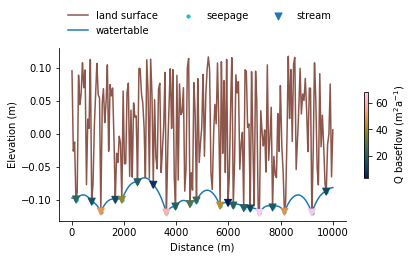

In [249]:
gr = (1 + np.sqrt(5)) / 2.0
fig, ax = pl.subplots(1, 1, figsize=(6, 6 / gr))
ax = h_and_z_fig(ax, x, h, z, None, stream_pts_bf, Q_baseflow_2D * year, stream_label='Q baseflow')

fig.tight_layout()

fig.savefig('fig/initial_baseflow_%s.pdf' % output_file_adj)
fig.savefig('fig/initial_baseflow_%s.png' % output_file_adj)

## Calculate 1D baseflow

the cross-sectional value of baseflow was converted to a 3D baseflow by multiplying with an upstream length: 

$$L_u = A r$$

where r is the aspect ratio (dimensionless)

$$Q_b = q_b  L_u$$

In [250]:
if fixed_upstream_length is True:
    upstream_length_bf = np.ones(len(contributing_area_bf)) * upstream_length
else:
    upstream_length_bf = contributing_area_bf * upstream_aspect_ratio

#if upstream_length.max() < min_upstream_length:
#    print('max upstream length is lower than threshold: %0.0f' % upstream_length.max())
#    upstream_length_correction = min_upstream_length / upstream_length.max()
#    upstream_length *= upstream_length_correction
#    print('multiplied upstream length with correction factor %0.2e' % upstream_length_correction)

# convert baseflow from m2/s to m3/sec using the upstream contributing area
baseflow = Q_baseflow_2D * upstream_length_bf

# calculate theoretical channel width
channel_width = k_w * baseflow ** omega
W = channel_width

## Calculate rainfall statistics for simulating overland flow

In [251]:
def find_gev_dist_params(D):
    
    """
    eqs. 8, 9 and 10 in Stowa (2019)
    """
    gev_loc = 1.02 * (0.239 - 0.0250 * np.log10(D/60.))**(-1/0.512)
    gev_disp = 0.478 - 0.0681 * np.log10(D)
    gev_shape = 0.118 - 0.266 *np.log10(D) + 0.0586 * (np.log10(D)**2)
    
    return gev_shape, gev_loc, gev_disp


def percipitation_return_time_func(gev_shape, gev_loc, gev_disp, return_time):
    
    """
    eq. 3 in Stowa (2019)
    
    """
    
    T = return_time
    
    kappa = gev_shape
    eta = gev_loc
    gamma = gev_disp
    
    if type(kappa) is float:
        if kappa != 0.0:
            x_gev = eta * (1 + gamma/kappa *  (1- T**(-kappa)))
        else:
            x_gev = eta * (1 + gamma * np.log(T))
    
    else:
        x_gev = eta * (1.0 + gamma/kappa *  (1.0- T**(-kappa)))
        x_gev0 = eta * (1.0 + gamma * np.log(T))
        x_gev[kappa == 0.0] = x_gev0[kappa == 0.0]
        
    return x_gev

hour = 3600.
day = 24 * hour
max_precip_freq = 30
precip_freqs = np.arange(1, max_precip_freq)

Ts = 1./precip_freqs

gev_shape, gev_loc, gev_disp = find_gev_dist_params(precipitation_duration)

precip_depths = percipitation_return_time_func(gev_shape, gev_loc, gev_disp, Ts) * 1e-3

# find cumulative total
precip_totals = precip_depths * precip_freqs
precip_total = np.sum(precip_depths * precip_freqs)

precip_depth_cum = np.cumsum(precip_totals)
ind = np.where(precip_depth_cum > (P * year))[0][0]

print('including first %i %0.0f hr precipitation events to arrive at total of %0.2f Peff / yr' 
      % (ind, precipitation_duration/hour, precip_depth_cum[ind-1]))

precip_depths = precip_depths[:ind]
precip_freqs = precip_freqs[:ind]

# find cumulative total
precip_totals = precip_depths * precip_freqs
precip_total = np.sum(precip_depths * precip_freqs)

including first 8 3 hr precipitation events to arrive at total of 0.68 Peff / yr


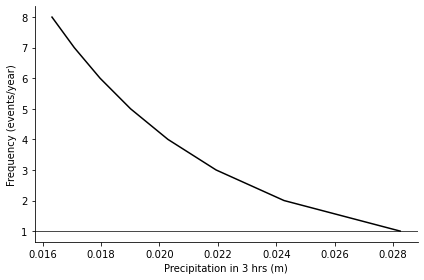

In [252]:
fig, ax = pl.subplots(1, 1, figsize=(6, 4))
ax.plot(precip_depths, precip_freqs, color='black')
ax.axhline(y=1, color='black', lw=0.7)
ax.set_ylabel('Frequency (events/year)')
ax.set_xlabel('Precipitation in %0.0f hrs (m)' % (precipitation_duration / 3600.))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('fig/precipitation_frequency_curve.pdf')

**Fig. caption** *Precipitation frequency curve for the Netherlands*

## Calculate saturation overland flow

In [253]:
def calculate_excess_precipitation(P_event, h, z, specific_yield, dxc):

    # calculate temporary watertable
    he = h + P_event / specific_yield

    # calculate precipitation excess above storage
    Pe_nodes = he - z
    Pe = (Pe_nodes[1:] + Pe_nodes[:-1]) / 2.0 * dxc * specific_yield

    Pe[Pe < 0] = 0

    # for each cell where watertable cross surface find intersection he and z
    dhe = np.diff(he)
    dze = np.diff(z)
    he_slope = dhe / dxc
    z_slope = dze / dxc

    xi = (z[:-1] - he[:-1]) / (he_slope - z_slope)
    in_cell = np.logical_and(xi > 0, xi < dx)

    ind_int = np.where(in_cell)[0]
    if np.any(in_cell):
        for i in ind_int:
            x1, x2 = i, i+1
            if he[x1] > z[x1] and he[x2] > z[x2]:
                raise ValueError
            if he[x1] > z[x1]:
                Pe[i] = (he[x1] - z[x1]) * xi[i] * specific_yield 
            elif he[x2] > z[x2]:
                Pe[i] = (he[x2] - z[x2]) * (dxc[i] - xi[i]) * specific_yield 
    
    if Pe.min() < 0:
        raise ValueError
    
    return Pe


def calculate_overland_flow_volume(P_event, dxc, z, h, specific_yield, 
                                   stream_pts_of, contributing_area_pts_of):
    
    """
    
    """
    
    P_excess = calculate_excess_precipitation(P_event, h, z, specific_yield, dxc)

    V_overland_2D = np.zeros(len(stream_pts_of))

    for pt_i, stream_pt_i, contributing_area_pt in zip(itertools.count(), 
                                                       stream_pts_of, 
                                                       contributing_area_pts_of):
        x1, x2 = contributing_area_pt
        V_overland_2D[pt_i] = np.sum(P_excess[x1:x2])
        
    return V_overland_2D, P_excess

In [254]:


#specific_yield = 0.0001

# find overland flow streams
z_depr = find_depressions(z)
stream_pts_of = np.where(z_depr)[0]

# Calculate contributing area overland flow
contributing_area_pts_of, contributing_area_of = calculate_contributing_area(x, z, stream_pts_of)

of_results = [calculate_overland_flow_volume(precip_depth, dxc, z, h, 
                                             specific_yield, 
                                             stream_pts_of, contributing_area_pts_of) 
                    for precip_depth in precip_depths]

V_of_2D = np.array([a for a,b in of_results])
P_excess = np.array([b for a,b in of_results])

if fixed_upstream_length is True:
    upstream_length_of = np.ones(len(contributing_area_of)) * upstream_length
else:
    upstream_length_of = contributing_area_of * upstream_aspect_ratio
    
V_of_3D = np.array([0.5 * V2D * upstream_length_of for V2D in V_of_2D])
#Vs_overland = np.array(Vs_overland_single) * precip_freqs
#Vs_overland = [V * freq for V, freq in zip(Vs_overland_single, precip_freqs)]


<ipython-input-253-4628f14b473a>:18: RuntimeWarning: divide by zero encountered in true_divide
  xi = (z[:-1] - he[:-1]) / (he_slope - z_slope)


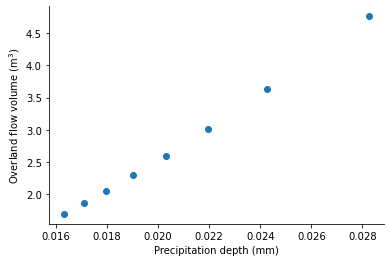

In [255]:
fig, ax = pl.subplots(1, 1)

ax.scatter(precip_depths, [np.max(V) for V in V_of_2D])
ax.set_xlabel('Precipitation depth (mm)')
ax.set_ylabel(r'Overland flow volume ($m^3$)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

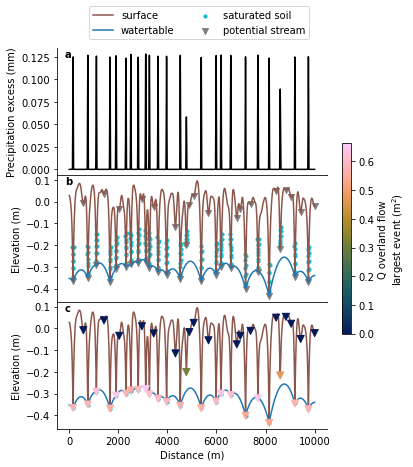

In [284]:
xc = (x[1:] + x[:-1]) / 2.0
zc = (z[1:] + z[:-1]) / 2.0

fig, axs = pl.subplots(3, 1, figsize=(6, 7), sharex=True)
axs[0].plot(xc, P_excess[0], color='black')
leg_surf, = axs[1].plot(x, z, color=land_surf_color, label='surface')
leg_h, = axs[1].plot(x, h, color=watertable_color, ls='-', label='watertable')

ind = P_excess[0] > 0
leg_p = axs[1].scatter(xc[ind], zc[ind], color=col_overland, marker='o', s=10, label='saturation overland flow')
#leg_s = axs[1].scatter(x[stream_pts_of], z[stream_pts_of], marker='v', color=stream_col, label='stream')
leg_s = axs[1].scatter(x[stream_pts_of], z[stream_pts_of], marker='v', color='gray', label='potential stream')

axs[0].set_ylabel('Precipitation excess (mm)')
axs[1].set_ylabel(ylabel)
axs[1].set_xlabel(xlabel)

labels = ['surface', 'watertable', 'saturated soil', 'potential stream']
legs = [leg_surf, leg_h, leg_p, leg_s]
#axs[1].legend(legs, labels, bbox_to_anchor=(1.02, 0.3), loc='lower left')
axs[0].legend(legs, labels, bbox_to_anchor=(0.1, 1.03), loc='lower left', ncol=2)

axs[2] = h_and_z_fig(axs[2], x, h, z, None, stream_pts_of, V_of_2D[0], 
                     stream_label='Q overland flow\nlargest event', stream_label_units=r'$m^2$', 
                     add_legend=False, cb_axs=axs, remove_top_ax=False)

for ax in axs:
    ax.spines['right'].set_visible(False)

axs[0].spines['top'].set_visible(False)

for i, panel in enumerate(axs):
    #panel.spines['top'].set_visible(False)
    #panel.spines['right'].set_visible(False)
    panel.text(0.03, 0.99, string.ascii_lowercase[i],
            weight='bold', transform=panel.transAxes, ha='left', va='top')


#fig.tight_layout()
fig.subplots_adjust(hspace=0.0, right=0.75)

fig.savefig('fig/initial_p_excess_%s.pdf' % output_file_adj)

**Fig. caption** *Calculated overland flow in streams*

In [257]:
precip_depths

array([0.0282421 , 0.02426399, 0.02193894, 0.02029017, 0.0190118 ,
       0.01796762, 0.01708502, 0.01632064])

## Calculate stream erosion due to baseflow

The sediment flux in stream channel $Q_s$ (m^3^ s^-1^) at carrying capcatity is given by (Tucker & Bras 1998, eq. 6):

$$Q_s = w k_f (Q/w)^m S^n$$

where $Q$ is water discharge, $W$ is width (m), $S$ is channel slope, $k_f$ (, $m$, $n$ are model parameters (units...).


new version

Tucker 2001, eq. 11:

$$C_s = W k_f \left( k_t \dfrac{Q}{W}^{m_f} S^{n_f} - \phi_c \right)^{p_f}$$

basically the same....


The erosion of a stream channel is quantified by taking the carrying capacity and dividing this by the length and width of the channel:

$$\dfrac{\partial z}{\partial t} = Q_s / (W L)$$

the width follows

$$W = k_w Q^\omega$$

where $k_w$ and $\omega$ are empirical parameters. We use values of $k_w = 3.65$ and $\omega = 0.5$ (ref).

There are two options for taking into account channel length (L). One is to use a fixed value for channel length. The second option is to use a variable length, and to instead keep the aspect ratio of the watershed for each stream constant. In this case channel length is assumed to be equal to the length of the contributing area in the 2D cross section (b), multiplied by a fixed aspect ratio (a):

$$L = b a$$

In [258]:
# fluvial sed transport flux (m3/s) due to baseflow
Cb = W * k_f * k_t * (baseflow / W)**m * S**n

# adjust stream erosion for ratio of channel width and grid cell
#q_soy = q_soy * channel_width / dx

# total sed flux in one timestep (m3)
Cbt = Cb * dt
                
# total volume eroded (taking into account porosity)
VEb = Cbt * (1 - phi)
                 
# calculate the change in z due to baseflow in one timestep
z_change_baseflow = VEb / W / upstream_length_bf

dz_bf = np.zeros_like(z)
dz_bf[stream_pts_bf] = z_change_baseflow

#print('baseflow (m3/s):\n', baseflow)
#print('baseflow (m/yr):\n', (baseflow * year / width / upstream_length_bf))
#print('total baseflow (m/yr):\n', np.sum(baseflow * year / width / upstream_length_bf))
#print('change in z in one timestep (%0.2e year) due to baseflow (m):' % (dt / year))
#print(z_change_baseflow)

## Calculate stream erosion due to overland flow


In [259]:
def calculate_sediment_flux_overland_flow(V0, L, S, St, kf, Km, n, m):
    
    """
    integrated sediment flux over time for a single overland flow event in a stream channel:
    
    V0 : initial volume of water to be discharged (m3)
    L : Length of channel
    S : Slope of channel bed along flow direction
    St : Slope of channel bed perpendicular to flow direction, assuming a triangular channel shape
    kf : empirical coefficient in sediment discharge equation (units...)
    Km : empirical coefficient in the Gauckler-Manning equation (units....)
    n : empirical coefficient in sediment discharge equation (units...)
    m : empirical coefficient in sediment discharge equation (units...)
    """
    
    t0 = np.inf
    t1 = 0.0
    
    # calculate constants in equation:
    a = kf * S**n * (Km *S**0.5 / St)**m
    b = ((V0 * St) / L) ** (-1./3.)
    c = (Km * S**0.5) / (3 * L)
    
    Vsa = a * (b + c * t0) ** (-4*m+1) / (-4*m*c + c) - a * (b + c * t1) ** (-4*m+1) / (-4*m*c + c)
    
    return Vsa


n_precip = len(precip_depths)
n_of_streams = len(stream_pts_of)
V_erosion_of = np.zeros((n_precip, n_of_streams))

for precip_j in range(n_precip):
    for pt_i in range(n_of_streams):
        #V_erosion_overland[pt_i] = overland_flow_erosion(k_f, transverse_gradient, K_n, St, Q_overland_str, uL)
        Vi = calculate_sediment_flux_overland_flow(V_of_3D[precip_j, pt_i], upstream_length_of[pt_i], S, St, k_f, K_n, n, m)
        if np.isnan(Vi) == False:
            V_erosion_of[precip_j, pt_i] = Vi
            
# calculate channel width during overland flow event
Q_of = V_of_3D / precipitation_duration
channel_width_of = k_w * Q_of ** omega
#channel_width_of_mean = np.mean(channel_width_of, axis=0)
#V_erosion_overland = 
V_erosion_of_rock = V_erosion_of / (1 - phi)
dz_of_1year = -V_erosion_of_rock / (upstream_length_of * channel_width_of)
dz_of_1year[np.isnan(dz_of_1year)] = 0.0
dz_of_1year_corrected = np.array([dzi * pfi for dzi, pfi in zip(dz_of_1year, precip_freqs)])
#dz_of_1year_corrected = dz_of_1year

dz_of_str_all_events = dz_of_1year_corrected * dt / precip_return_time
dz_of_str = np.sum(dz_of_str_all_events, axis=0)

dz_of = np.zeros_like(z)

dz_of[stream_pts_of] = dz_of_str

#dz_erosion_overland *= n_overland_events
#dz_erosion_overland[:] = 0

#print('Q overland flow per year for streams for largest event (m2/yr): ', V_of_2D[0])

print('total Q overland flow per year for streams for largest event (m2/yr): ', np.sum(V_of_2D[0]))

print('Total precip for largest event (m2) = ', (precip_depths[0] * width))


#print('eroded volume largest event (m3/yr)\n', V_erosion_of[0])

#print('change in z due to largest event (m/yr)\n', dz_of_1year_corrected[0])

#print('change in z due to overland flow in one timestep of %0.2e yr (m):' % (dt/year))
#print(dz_of_str)

total Q overland flow per year for streams for largest event (m2/yr):  87.19848418050506
Total precip for largest event (m2) =  282.42100396903606


<ipython-input-259-8c16ac6d15f8>:21: RuntimeWarning: divide by zero encountered in double_scalars
  b = ((V0 * St) / L) ** (-1./3.)
<ipython-input-259-8c16ac6d15f8>:46: RuntimeWarning: invalid value encountered in true_divide
  dz_of_1year = -V_erosion_of_rock / (upstream_length_of * channel_width_of)


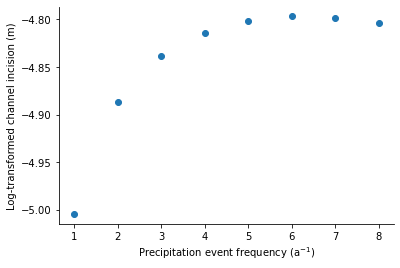

In [260]:
indm = np.argmax(-dz_of_1year_corrected[0])

#max_dzs_of = np.max(-dz_of_1year_corrected, axis=1)
max_dzs_of = -dz_of_1year_corrected[:, indm]

fig, ax = pl.subplots(1, 1)

ax.scatter(precip_freqs, np.log10(max_dzs_of))

ax.set_xlabel(r'Precipitation event frequency ($a^{-1}$)')
ax.set_ylabel('Log-transformed channel incision (m)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax2 = ax.twiny()
#ax2.set_xlim(ax.get_xlim())

#ax.set_yscale('log')
fig.savefig('fig/channel_incision_per_event.pdf')

In [261]:
max_dzs_of.sum()


0.00011609298403648293

## Calculate hillslope diffusion

Hillslope erosion follows

$$C_h = K_d \dfrac{\partial z}{\partial x}$$

and the continuity eq to yield

$$\dfrac{\partial z}{\partial t} = \dfrac{\partial \left( K_d {\frac{\partial z}{\partial x}} \right)}{\partial x}$$

In [262]:
def hillslope_diffusion(K_d, z, z_gradient):

    """
    calculate hillslope diffusion flux

    :param K_d:
    :param z:
    :param z_gradient:
    :return:
    """

    q_sh = -K_d * z_gradient

    return q_sh

z_gradient = np.diff(z) / np.diff(x)
q_hillslope = hillslope_diffusion(K_d, z, z_gradient)

dz_hillslope = np.zeros_like(z)

# in-plane transport
dz_hillslope[1:] -= - dt * q_hillslope / dx
dz_hillslope[:-1] += - dt * q_hillslope / dx

print('change in z due to hillslope diffusion in one timestep (m):')
print(dz_hillslope.min(), dz_hillslope.max(), dz_hillslope.mean())

change in z due to hillslope diffusion in one timestep (m):
-1.2323436051639931e-05 1.3217959204131024e-05 7.199780051661553e-24


## Sum erosion and show new surface after t=x years

In [263]:
dz = np.zeros_like(z)
dz += dz_hillslope
dz += dz_of
dz[stream_pts_bf] += z_change_baseflow

z_old = z.copy()

# correct timestep
relief = z.max() - z.min()

max_dz = np.max(np.abs(dz))

max_allowed_dz = relief * max_rel_dz

if  max_dz > max_allowed_dz:
    dt_corr = dt * max_allowed_dz / max_dz
    dz_corr = dz * max_allowed_dz / max_dz
    z += dz_corr
    #time += dt_corr
else:
    z += dz
    #time += dt

In [264]:
z_change_baseflow

array([5.01254221e-07, 3.71237081e-07, 1.02286981e-06, 3.18695348e-07,
       8.11750510e-07, 4.41502691e-07, 1.98200450e-07, 1.19741162e-06,
       4.56166648e-07, 6.13526080e-07, 5.39298556e-07, 8.86014853e-07,
       1.06322358e-07, 4.63133607e-07, 4.75946426e-07, 3.07970336e-07,
       1.35042475e-06, 4.19610771e-07, 9.95092587e-07, 1.30612191e-06,
       3.06887573e-07])

In [265]:
def h_and_z_change_fig(x, z, z_old, h, h_old, stream_pts, Q_stream):
    
    cmap = pl.get_cmap('tab20')

    land_surf_color = cmap(10.0 * 1/20.)
    watertable_color = cmap(0.0 * 1/20.)

    past_surf_color = cmap(11.0 * 1/20.)
    past_wt_color = cmap(1.0 * 1/20.)
    init_surf_color = cmap(11.0 * 1/20.)
    init_wt_color = cmap(1.0 * 1/20.)

    col_overland = cmap(18.0 * 1/20.)
    col_baseflow = cmap(8.0 * 1/20.)
    col_hillslope = cmap(3.0 * 1/20.)

    seepage_color = col_overland
    stream_color = col_baseflow
    
    fig, ax = pl.subplots(1, 1)
    
    ax.plot(x, h_old, color=past_surf_color, label='old h', ls=':')
    ax.plot(x, h, color=watertable_color, label='h')
    ax.plot(x, z_old, color='gray', label='old surface', ls='-', lw=1.5)
    ax.plot(x, z, color=land_surf_color, label='surface')
    
    if stream_pts is not None:
        if Q_stream is None:
            ax.scatter(x[stream_pts], z_old[stream_pts], color='gray', marker='v', label='stream')
            ax.scatter(x[stream_pts], z[stream_pts], color=stream_color, marker='v', label='stream')
        else:
            sc = ax.scatter(x[stream_pts], z[stream_pts], c=Q_stream, marker='v', s=50, label='stream', zorder=100)
            cb = fig.colorbar(sc, shrink=0.5)
            cb.set_label(r'Q ($m^2 a^{-1}$)')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False, bbox_to_anchor= (1.02, 0.5), ncol=1, 
            borderaxespad=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig

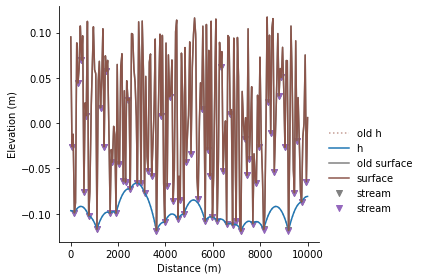

In [266]:
h_old = h
fig = h_and_z_change_fig(x, z, z_old, h, h_old, stream_pts_of, None)

fig.tight_layout()

fig.savefig('fig/first_model_timestep_%s.pdf' % output_file_adj)

## Calculate new hydraulic head

In [267]:
def calculate_h_and_seepage(x, z, T, rch, max_h_error=0.05, return_all=False, verbose=False):
    
    relief = z.max() - z.min()
    max_h_error = 0.05 * relief
    if max_h_error > 0.05:
        max_h_error = 0.05
    
    # calculate width of cells
    dxc = np.diff(x)

    # calculate width between nodes
    dxn = np.zeros_like(x)
    dxn[1:] += dxc / 2.0
    dxn[:-1] += dxc / 2.0
    
    # set limit for acceptable inflow from seepage nodes
    if type(rch) is float:
        inflow_lim = rch * dxn * 2
    else:
        inflow_lim = rch.mean() * dxn * 2
    
    h = np.ones_like(z) * z.min()
    
    seepage_pts = []
    #seepage_pts = stream_pts.tolist()
    
    max_iter = int(len(x) / 1)
    keep_going = True
    h_converged = False

    n_iter = 0
    
    hs = []
    seepage_pts_all = []
    seepage_bool = np.full((len(x)), False)
    
    while keep_going is True and n_iter < max_iter:
        
        if verbose is True:
            print('iteration %i, seepage pts = %i' % (n_iter, len(seepage_pts)))
        
        if len(seepage_pts) > 0:
        
            seepage_pts_corr, nr = remove_inflow_seepage_nodes(seepage_pts, x, h, T, inflow_lim)

            #if nr < -1:
            seepage_pts = seepage_pts_corr
            seepage_xs =  x[seepage_pts]
            seepage_hs = z[seepage_pts]

            h = calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs)
            
        seepage_pts = find_next_seepage_pt(h, z, seepage_bool, seepage_pts)

        seepage_xs =  x[seepage_pts]
        seepage_hs = z[seepage_pts]
        seepage_bool[np.array(seepage_pts)] = True
        
        h = calculate_h(x, T, rch, seepage_pts, seepage_xs, seepage_hs)
                
        # check if h is below the surface everywhere
        if np.any(h > (z + max_h_error)) == False:
            keep_going = False
            h_converged = True

        n_iter += 1
        
        if return_all is True:
            hs.append(h)
            seepage_pts_all.append(seepage_pts.copy())
    
    # correct values of h to avoid issues with precipitation excess calculation
    h[h > z] = z[h > z]
    
    if h_converged is True:
        if verbose is True:
            print('converged after %i iterations' % n_iter)
    else:
        print('warning, convergence h calculation failed after %i iterations' % n_iter)
    
    if return_all is True:
        return h, seepage_pts, hs, seepage_pts_all
    else:
        return h, seepage_pts

In [268]:
h, seepage_pts, hs, seepage_pts_all = calculate_h_and_seepage(x, z, T, rch, return_all=True)

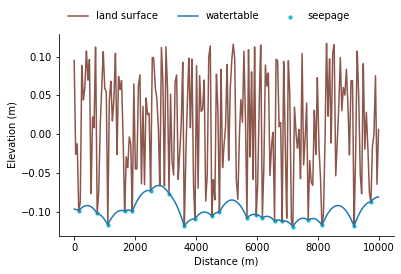

In [269]:
gr = (1 + np.sqrt(5)) / 2.0
fig, ax = pl.subplots(1, 1, figsize=(6, 6 / gr))
fig = h_and_z_fig(ax, x, h, z, seepage_pts, None, None)

## Put everything in a function and a loop and model erosion over longer timescale

In [270]:
report_interval = 200

#total_runtime = 1e6 * year

#from ipywidgets import FloatProgress
#from IPython.display import display

#f = FloatProgress(min=0, max=total_runtime / year) # instantiate the bar
#display(f) # display the bar

# init:

## Params

## Set up grid

## set up rainfall depths array

## generate initial topography

# value for reclaculating slope


##########
# set up arrays for loop

seepage_bool = np.zeros_like(z, dtype=bool)

dz_bf = np.zeros_like(z)
dz_of = np.zeros_like(z)
dz_hillslope = np.zeros_like(z)

zs = []
hs = []
times = []
streams_bf_all = []
streams_of_all = []

time = 0
ts_report = 0

ti = 0

Pes = []
Vos = []

# stream locations for overland & baseflow
strs_of = []
strs_bf = []

# number of active streams
n_str_of = []
n_str_bf = []

# upstream length
uls_of = []
uls_bf = []

# contributing areas
cas_bf = []
cas_of = []

# baseflow and overland flow fluxes
Q_baseflows = []
Q_overland_flows = []
Q_baseflow_nodes_i = np.zeros_like(x)
Q_overland_flow_nodes_i = np.zeros_like(x)
Q_baseflow_nodes = []
Q_overland_flow_nodes = []

# erosion overland flow, baseflow, hillslope diff
erosion_bf_per_yr = []
erosion_of_per_yr = []
erosion_hd_per_yr = []

dzs = []

n_str_of_i = 0

print('starting model runs')

while time < total_runtime:
    
    if ti < 20 or ts_report >= report_interval:
        print('timestep %i, time = %0.1f yrs of %0.0f yrs, active streams = %i, min z = %0.2f' 
              % (ti, time/year, total_runtime/year, n_str_of_i, z.min()))
        ts_report = 0
        
    if ti >= 20:
        report_interval = 10
    if ti >= 100:
        report_interval = 100
    if ti >= 500:
        report_interval = 500
        
    if np.any(np.isnan(z)):
        raise ValueError('error, nan value in elevation array z')
    
    ## Calculate stream locs for overland flow
    z_depr = find_depressions(z)
    stream_pts_of = np.where(z_depr)[0]    
    
    ## calc overland flow
    contributing_area_pts_of, contributing_area_of = calculate_contributing_area(x, z, stream_pts_of)
    of_results = [calculate_overland_flow_volume(precip_depth, dxc, z, h, specific_yield, 
                                                 stream_pts_of, contributing_area_pts_of) 
                          for precip_depth in precip_depths]
    V_of_2D = np.array([a for a, b in of_results])
    Q_of_2D = np.sum(V_of_2D, axis=0) / precip_return_time
    P_excess = np.array([b for a, b in of_results])
    Q_overland_flow = np.sum(P_excess) / precip_return_time
    
    Q_overland_flow_nodes_i[:] = 0
    Q_overland_flow_nodes_i[stream_pts_of] = Q_of_2D 
    
    ## calculate partitioning overland flow and recharge
    pot_rch_per_event = np.array([Pdi * pfi - (Poi/dxc) 
                                for Pdi, pfi, Poi in zip(precip_depths, precip_freqs, P_excess)])
    pot_rch = np.sum(pot_rch_per_event, axis=0)
    
    # substract ET rate from potential rch
    rch_all_nodes = pot_rch / year - ET
    
    # make sure no negative rch values
    rch_all_nodes[rch_all_nodes < 0] = 0.0
    
    if average_rch is True:
        rch = rch_all_nodes.mean()
    else:
        rch = rch_all_nodes
        rch[rch < 0] = 0
    
    ## Calculate h and seepage pts
    h, seepage_pts = calculate_h_and_seepage(x, z, T, rch, return_all=False)
    #print('done calculating h')
    
    seepage_bool[:] = False
    seepage_bool[seepage_pts] = True
    stream_pts_bf = np.where(np.logical_and(seepage_bool, z_depr))[0]
    
    ## calc contributing area and baseflow
    contributing_area_pts_bf, contributing_area_bf = calculate_contributing_area(x, h, stream_pts_bf)
    #Q_baseflow_2D = rch * contributing_area_bf
    Q_baseflow_2D = calculate_baseflow(x, h, T)
    Q_baseflow_nodes_i[:] = 0
    Q_baseflow_nodes_i[stream_pts_bf] = Q_baseflow_2D
    
    if fixed_upstream_length is True:
        upstream_length_bf = np.ones(len(contributing_area_bf)) * upstream_length
    else:
        upstream_length_bf = contributing_area_bf * upstream_aspect_ratio
    
    baseflow = Q_baseflow_2D * upstream_length_bf
    
    # store data for baseflow:
    uls_bf.append(upstream_length_bf)
    cas_bf.append(contributing_area_pts_bf)
    n_str_bf.append(len(stream_pts_bf))
    strs_bf.append(stream_pts_bf)
    Q_baseflows.append(np.sum(Q_baseflow_2D))
    Q_baseflow_nodes.append(Q_baseflow_nodes_i.copy())
    
    ## recalculate stream slope for baseflow streams
    z_bf = z[stream_pts_bf]
    z_origin_bf = upstream_length_bf * S_init
    S_bf = (z_origin_bf - z_bf) / upstream_length_bf
    
    ## calc baseflow erosion
    W_bf = k_w * baseflow ** omega
    Cb = W_bf * k_f * k_t * (baseflow / W_bf)**m * S_bf**n
    Cbt = Cb * dt
    VEb = Cbt / (1 - phi)
    
    # calculate resultig incision. assuming a uniform ditribution over the channel and a linear
    # increase from orogin to the position of the cross-section
    z_change_baseflow = -2 * VEb / W_bf / upstream_length_bf
    dz_bf[:] = 0.0
    dz_bf[stream_pts_bf] = z_change_baseflow
    
    erosion_bf_per_yr_i = np.sum(VEb / (dt / year) / upstream_length_bf)
    erosion_bf_per_yr.append(erosion_bf_per_yr_i)
        
    if fixed_upstream_length is True:
        upstream_length_of = np.ones(len(contributing_area_of)) * upstream_length
    else:
        upstream_length_of = contributing_area_of * upstream_aspect_ratio
    
    V_of_3D = np.array([V2D * upstream_length_of for V2D in V_of_2D])
    
    # store data for overland flow
    n_str_of.append(np.sum(V_of_2D[0] > 0.0))
    #Pes.append(np.sum(P_excess))
    Q_overland_flows.append(Q_overland_flow)
    Vos.append(np.sum(V_of_2D))
    uls_of.append(upstream_length_of)
    cas_of.append(contributing_area_pts_of)
    strs_of.append(stream_pts_of)
    Q_overland_flow_nodes.append(Q_overland_flow_nodes_i.copy())
    
    ## recalculate stream slope for overland flow streams
    z_of = z[stream_pts_of]
    z_origin_of = upstream_length_of * S_init
    S_of = (z_origin_of - z_of) / upstream_length_of
    
    ## calc overland flow erosion
    n_precip = len(precip_depths)
    n_of_streams = len(stream_pts_of)
    V_erosion_of = np.zeros((n_precip, n_of_streams))
    
    for precip_j in range(n_precip):
        for pt_i in range(n_of_streams):
            Vi = calculate_sediment_flux_overland_flow(V_of_3D[precip_j, pt_i], 
                                                       upstream_length_of[pt_i], 
                                                       S_of[pt_i], St, k_f, K_n, n, m)
            if np.isnan(Vi) == False:
                V_erosion_of[precip_j, pt_i] = Vi

    # calculate channel width during overland flow event
    Q_of = V_of_3D / precipitation_duration
    channel_width_of = k_w * Q_of ** omega
    V_erosion_of_rock = V_erosion_of / (1 - phi)
    
    # distribute erosion over the entire channel (inc. the upstream reaches)
    # assuming a linear increase in erosion up the the position of the cross sect.
    dz_of_1year = -2.0 * V_erosion_of_rock / (upstream_length_of * channel_width_of)
    dz_of_1year[np.isnan(dz_of_1year)] = 0.0
    dz_of_1year_corrected = np.array([dzi * pfi for dzi, pfi in zip(dz_of_1year, precip_freqs)])
    dz_of_str_all_events = dz_of_1year_corrected * dt / precip_return_time
    dz_of_str = np.sum(dz_of_str_all_events, axis=0)
    dz_of[:] = 0.0
    dz_of[stream_pts_of] = dz_of_str
    
    erosion_of_per_yr_i = np.sum(V_erosion_of / upstream_length_of)
    erosion_of_per_yr.append(erosion_of_per_yr_i)
    
    ## calc hillslope diffusion erosion
    z_gradient = np.diff(z) / np.diff(x)
    q_hillslope = hillslope_diffusion(K_d, z, z_gradient)
    dz_hillslope[:] = 0.0
    dz_hillslope[1:] -= - dt * q_hillslope / dx
    dz_hillslope[:-1] += - dt * q_hillslope / dx
    
    VE_hs = (1 - phi) * dz_hillslope / (dt / year) * dxn
    erosion_hd_per_yr_i = np.sum(VE_hs)
    erosion_hd_per_yr.append(erosion_hd_per_yr_i)
    
    ## Sum erosion and calculate new surface elevation
    dz = dz_bf + dz_of + dz_hillslope
    
    # correct timestep
    relief = z.max() - z.min()
    
    max_dz = np.max(np.abs(dz))
    
    min_allowed_dz = relief * min_rel_dz
    max_allowed_dz = relief * max_rel_dz
    
    if min_allowed_dz < 0.01:
        min_allowed_dz = 0.01
    #max_allowed_dz = 0.5
    
    dzs.append(dz)
    
    if  max_dz < min_allowed_dz:
        dt_corr = dt * min_allowed_dz / max_dz
        dz_corr = dz * min_allowed_dz / max_dz
        z += dz_corr
        time += dt_corr
        
    elif max_dz > max_allowed_dz:
        dt_corr = dt * max_allowed_dz / max_dz
        dz_corr = dz * max_allowed_dz / max_dz
        z += dz_corr
        time += dt_corr
        #f.value += dt_corr / year
    else:
        z += dz
        time += dt
        #f.value += dt / year
    
    if np.any(np.isnan(z)):
        raise ValueError('error, nan value in elevation array z')
    
    zs.append(z.copy())
    hs.append(h)
    
    times.append(time)
    ti += 1
    ts_report += 1
    
    n_str_of_i = n_str_of[-1]
    
# End loop
times = np.array(times)

# convert output to arrays
Q_baseflows = np.array(Q_baseflows)
Q_overland_flows = np.array(Q_overland_flows)
n_str_of = np.array(n_str_of)

erosion_of_per_yr = np.array(erosion_of_per_yr)
erosion_bf_per_yr = np.array(erosion_bf_per_yr)
erosion_hd_per_yr = np.array(erosion_hd_per_yr)

dzs = np.array(dzs)
Q_baseflow_nodes = np.array(Q_baseflow_nodes)
Q_overland_flow_nodes = np.array(Q_overland_flow_nodes)

starting model runs
timestep 0, time = 0.0 yrs of 100000 yrs, active streams = 0, min z = -0.12
timestep 1, time = 14.4 yrs of 100000 yrs, active streams = 63, min z = -0.13
timestep 2, time = 25.5 yrs of 100000 yrs, active streams = 66, min z = -0.13
timestep 3, time = 40.5 yrs of 100000 yrs, active streams = 65, min z = -0.14
timestep 4, time = 61.3 yrs of 100000 yrs, active streams = 64, min z = -0.15
timestep 5, time = 89.3 yrs of 100000 yrs, active streams = 64, min z = -0.16
timestep 6, time = 129.7 yrs of 100000 yrs, active streams = 64, min z = -0.17
timestep 7, time = 185.0 yrs of 100000 yrs, active streams = 63, min z = -0.18
timestep 8, time = 253.4 yrs of 100000 yrs, active streams = 63, min z = -0.19
timestep 9, time = 351.0 yrs of 100000 yrs, active streams = 61, min z = -0.19
timestep 10, time = 520.5 yrs of 100000 yrs, active streams = 60, min z = -0.20
timestep 11, time = 841.8 yrs of 100000 yrs, active streams = 58, min z = -0.20
timestep 12, time = 1335.3 yrs of 1000

<ipython-input-259-8c16ac6d15f8>:21: RuntimeWarning: divide by zero encountered in double_scalars
  b = ((V0 * St) / L) ** (-1./3.)
<ipython-input-270-7661a65d1700>:225: RuntimeWarning: invalid value encountered in true_divide
  dz_of_1year = -2.0 * V_erosion_of_rock / (upstream_length_of * channel_width_of)
<ipython-input-253-4628f14b473a>:18: RuntimeWarning: divide by zero encountered in true_divide
  xi = (z[:-1] - he[:-1]) / (he_slope - z_slope)


timestep 15, time = 3602.9 yrs of 100000 yrs, active streams = 52, min z = -0.22
timestep 16, time = 4685.8 yrs of 100000 yrs, active streams = 51, min z = -0.22
timestep 17, time = 6130.9 yrs of 100000 yrs, active streams = 49, min z = -0.22
timestep 18, time = 6950.6 yrs of 100000 yrs, active streams = 47, min z = -0.23
timestep 19, time = 8414.6 yrs of 100000 yrs, active streams = 47, min z = -0.24
timestep 29, time = 23812.4 yrs of 100000 yrs, active streams = 35, min z = -0.29
timestep 39, time = 36713.4 yrs of 100000 yrs, active streams = 36, min z = -0.32
timestep 49, time = 48282.7 yrs of 100000 yrs, active streams = 27, min z = -0.34
timestep 59, time = 62540.4 yrs of 100000 yrs, active streams = 25, min z = -0.37
timestep 69, time = 74230.9 yrs of 100000 yrs, active streams = 25, min z = -0.39
timestep 79, time = 88016.7 yrs of 100000 yrs, active streams = 24, min z = -0.42


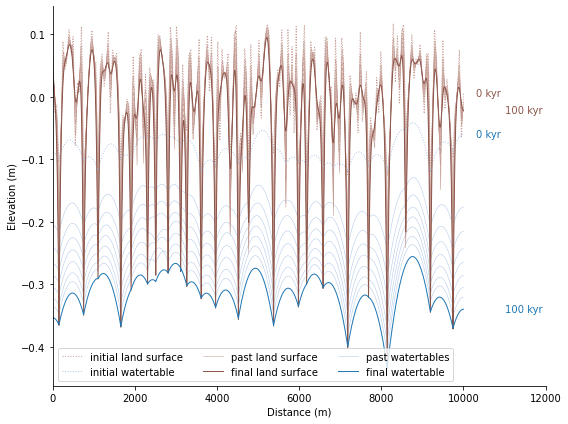

In [271]:
lw1=0.5
lw2=1.0

fig, ax = pl.subplots(1, 1, figsize=(8, 6))

ax.set_aspect('auto')

if len(hs) > 7:
    plot_int = int(len(hs) / 7.0)
else:
    plot_int = 1
    
plot_times = np.linspace(times[0], times[-1], 9)[1:-1]
plot_inds = np.array([np.argmin(np.abs(p - times)) for p in plot_times])

for pi in plot_inds:
    leg_s, = ax.plot(x, zs[pi], color=past_surf_color, lw=lw1)
    leg_h, = ax.plot(x, hs[pi], color=past_wt_color, lw=lw1)
    #tekst = '%0.0f yr' % (time / year)
    #ax.text(x[-1] * 1.05, hi[-1], tekst, ha='left', color='blue')

tekst = '0 kyr' % (times[-1] / year / 1e3)
ax.text(x[-1] * 1.03, zs[0][-1], tekst, ha='left', va='center', color=land_surf_color)
ax.text(x[-1] * 1.03, hs[0][-1], tekst, ha='left', va='center', color=watertable_color)

tekst = '%0.0f kyr' % (times[-1] / year / 1e3)
ax.text(x[-1] * 1.10, zs[-1][-1], tekst, ha='left', va='center', color=land_surf_color)
ax.text(x[-1] * 1.10, hs[-1][-1], tekst, ha='left', va='center', color=watertable_color)

ax.set_xlim(0, x[-1] * 1.2)

leg_sn0, = ax.plot(x, zs[0], color=init_surf_color, ls=':', lw=lw2)
leg_hn0, = ax.plot(x, hs[0], color=init_wt_color, ls=':', lw=lw2)  

leg_sn, = ax.plot(x, zs[-1], color=land_surf_color, lw=lw2)
leg_hn, = ax.plot(x, hs[-1], color=watertable_color, lw=lw2)  
#ax.plot(x, hs[0], color='lightblue', lw=lw2)  

ax.legend([leg_sn0, leg_hn0, leg_s, leg_sn, leg_h, leg_hn], 
          ['initial land surface', 'initial watertable', 
           'past land surface', 'final land surface', 
           'past watertables', 'final watertable'],
         ncol=3)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('fig/modelled_surface_and_watertable_%s.pdf' % output_file_adj)

**Fig caption** *Modeled elevation and watertable over time*

## Make animation of land surface & watertable over time

saving animation as fig/model_animation_id_369_2-4-2021.gif
done


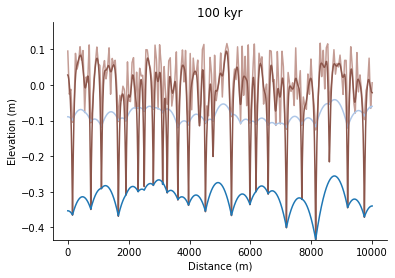

In [272]:
wt_col = watertable_color
wt_col_alt = past_wt_color
surface_col = land_surf_color
surface_col_alt = past_surf_color

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

def init():
    lz.set_data([], [])
    lh.set_data([], [])
    return line,

def animate(i, ax, tp, x, zs, hs, lz, lh, title, zmax):
    
    lz.set_data(x, zs[i])
    lh.set_data(x, hs[i])
    
    title.set_text('%0.0f kyr' % (tp[i]))
    
    ax.set_ylim(zs[i].min(), zmax)
    
    return lz, lh,


n_frames = 100
plot_times = np.linspace(times[0], times[-1], n_frames)
plot_inds = np.array([np.argmin(np.abs(p - times)) for p in plot_times])


fig, ax = pl.subplots(1, 1)

title = ax.set_title('%0.0f kyr' % (times[0] / kyr))

li, = ax.plot(x, zs[0], color=surface_col_alt)
li, = ax.plot(x, hs[0], color=wt_col_alt)
lz, = ax.plot(x, zs[0], color=surface_col)
lh, = ax.plot(x, hs[0], color=wt_col)

#ax.set_ylim(zs[0].max() * 1.1, zs[-1].min())

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#n_times = n_frames
#n_times = 10

zmax = zs[0].max() * 1.5

zsp = [zs[i] for i in plot_inds]
hsp = [hs[i] for i in plot_inds]
tp = [times[i]/kyr for i in plot_inds]

anim = FuncAnimation(fig, animate, n_frames, fargs=(ax, tp, x, zsp, hsp, lz, lh, title, zmax),
                     interval=200, blit=True)

fn = 'fig/model_animation_%s.gif' % output_file_adj

#writervideo = animation.FFMpegWriter(fps=60) 

print('saving animation as %s' % fn)
anim.save(fn, writer="pillow")
print('done')
#anim.save(fn)

## Make a figure with three timeslices & fluxes & erosions in top panels

Text(0, 0.5, 'Elevation change ($m\\;a^{-1}$)')

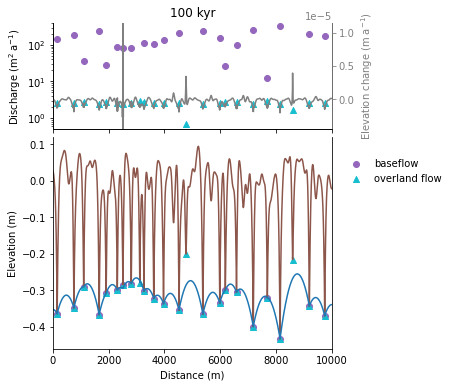

In [273]:
from matplotlib.gridspec import GridSpec

nplots = 1
n_times = len(zs)


plot_times = np.linspace(times[0], times[-1], nplots + 1)[1:]
output_timeslices = np.array([np.argmin(np.abs(p - times)) for p in plot_times])

#output_timeslices = (np.linspace(0, n_times-1, nplots + 1)[1:]).astype(int)

nrows = 2
ncols = nplots

fig, axs = pl.subplots(nrows, ncols, figsize=(nplots * 5, 6),
                       sharex='col', sharey='row',
                      gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05, 'wspace': 0.07})
axs = axs.ravel()

taxs = [axs[i] for i in range(nplots)]
baxs = [axs[nplots + i] for i in range(nplots)]

raxs = [ax.twinx() for ax in taxs]

# get min max values of fluxes
qs_comb = np.vstack([Q_baseflow_nodes[output_timeslices], 
                          Q_overland_flow_nodes[output_timeslices]])
ind = qs_comb > 0
qmins = np.min(qs_comb[ind])
qmaxs = np.max(qs_comb[ind])

#
for ts, tax, rax, bax in zip(output_timeslices, taxs, raxs, baxs):
    
    # surface and wataertable
    bax.plot(x, zs[ts], color=surface_col)
    bax.plot(x, hs[ts], color=wt_col)

    # erosion
    rax.plot(x, dzs[ts], color='gray', zorder=1)
    rax.set_ylim(dzs[output_timeslices].min(), dzs[output_timeslices].max())

    # fluxes
    tax.set_yscale('log')
    
    ind = Q_baseflow_nodes[ts] > 0
    l_bf = tax.scatter(x[ind], Q_baseflow_nodes[ts][ind] * year,
                       marker='o', color=col_baseflow, zorder=2)
    bax.scatter(x[ind], zs[ts][ind], marker='o', color=col_baseflow)#, facecolor='None')
    
    ind = Q_overland_flow_nodes[ts] > 0
    l_of = tax.scatter(x[ind], Q_overland_flow_nodes[ts][ind] * year, marker='^', 
                       color=col_overland, zorder=2)
    bax.scatter(x[ind], zs[ts][ind], marker='^', color=col_overland)#, facecolor='None')
    
    if tax == taxs[-1]:
        labels = ['baseflow', 'overland flow']
        tax.legend([l_bf, l_of], labels, 
                   frameon=False, ncol=1, 
                   bbox_to_anchor=[1.02, -0.2], loc='upper left')
        
    tax.set_ylim(qmins * year * 0.75, qmaxs * year * 1.25)
    
    bax.set_xlim(x.min(), x.max())
    
    tax.set_title('%0.0f kyr' % (times[ts] / kyr))

#labels = ['baseflow', 'overland flow']
#fig.legend([l_bf, l_of], labels, frameon=False, ncol=2, loc='lower center')

if nplots > 1:
    for rax in raxs[:-1]:
        rax.set_yticks([])
        rax.set_ylabel('')

for ax in baxs:
    ax.set_xlabel('Distance (m)')
    ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)

for tax, rax in zip(taxs, raxs):
    tax.spines['top'].set_visible(False)
    rax.spines['top'].set_visible(False)
    
for rax in raxs:
    rax.spines['right'].set_color('grey')
    rax.yaxis.label.set_color('grey')
    rax.tick_params(axis='y', colors='grey')
    
baxs[0].set_ylabel('Elevation (m)')
taxs[0].set_ylabel(r'Discharge ($m^2\;a^{-1}$)')
raxs[-1].set_ylabel(r'Elevation change ($m\;a^{-1}$)')

**Fig. caption** *Modelled water fluxes and elevation change (top panel) and topography and watertable (bottom panel)*

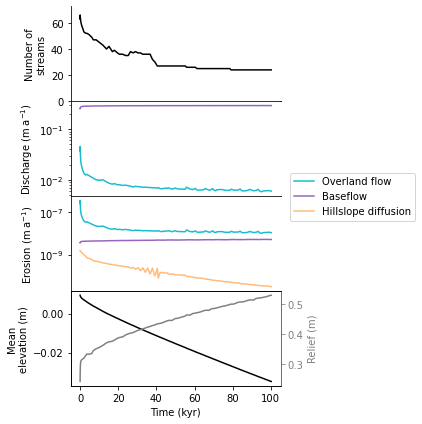

In [274]:
fig, axs = pl.subplots(4, 1, sharex=True, figsize=(6, 6))

axs[0].plot(times / kyr, n_str_of, color='black', label='overland flow')
axs[0].set_ylabel('Number of\nstreams')
axs[0].set_ylim(0, n_str_of.max() * 1.1)

bf = np.sum(Q_baseflow_2D) * year
axs[1].plot(times / kyr, Q_baseflows * year / width, 
            color=col_baseflow)
axs[1].plot(times / kyr, Q_overland_flows * year / width, 
            color=col_overland)
axs[1].set_ylabel(r'Discharge ($m\;a^{-1}$)')

lo, = axs[2].plot(times / kyr, erosion_of_per_yr / width, 
                  color=col_overland, label='overland\nflow')
lb, = axs[2].plot(times / kyr, erosion_bf_per_yr / width, 
                  color=col_baseflow, label='baseflow')
lh, = axs[2].plot(times / kyr, erosion_hd_per_yr / width, 
                  color=col_hillslope, label='hillslope\ndiffusion')
axs[2].set_ylabel(r'Erosion ($m\;a^{-1}$)')

legs = [lo, lb, lh]
labels = ['Overland flow', 'Baseflow', 'Hillslope diffusion']
axs[2].legend(legs, labels, bbox_to_anchor=(1.02, 1.3), loc='upper left')

zmn = np.array([np.mean(zi) for zi in zs])
axs[3].plot(times / kyr, zmn, color='black')
axs[3].set_ylabel('Mean\nelevation (m)')

axr = axs[3].twinx()
relief = np.array([np.max(zi) - np.min(zi) for zi in zs])
axr.plot(times / kyr, relief, color='gray')
axr.set_ylabel('Relief (m)')
axr.spines['right'].set_color('gray')
axr.yaxis.label.set_color('gray')
axr.tick_params(axis='y', colors='gray')


axs[-1].set_xlabel('Time (kyr)')

fig.tight_layout()

fig.subplots_adjust(hspace=0.0)

axs[0].spines['top'].set_visible(False)

for ax in axs[:-1]:
    ax.spines['right'].set_visible(False)

fig.savefig('fig/overview_variables_vs_time_%s.pdf' % output_file_adj)

axs[1].set_yscale('log')
axs[2].set_yscale('log')

fig.savefig('fig/overview_variables_vs_time_log_%s.pdf' % output_file_adj)

**Fig. caption** *Number of active streams and overland flow over time*

## Make figure with two streams after a small number of timesteps to illustrate model

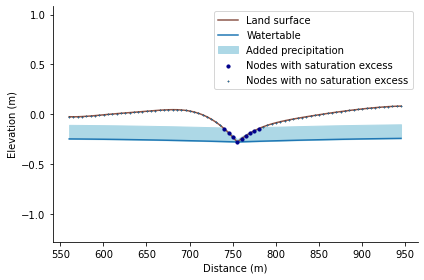

In [275]:
ts = 50

# find two streams
xs1 = np.where(Q_baseflow_nodes[ts] > 0)[0][1] 
xs2 = np.where(Q_baseflow_nodes[ts] > 0)[0][2]

dsx = xs2 - xs1
xb = int(dsx / 2.0)
xbb = 4
x1 = xs1 - xb - xbb
x2 = xs1 + xb + xbb

xi = x[x1:x2]
hi = hs[ts][x1:x2]
zi = zs[ts][x1:x2]
Pi = precip_depths[0]

Si = (zi - hi) * specific_yield

stored_p = np.zeros_like(hi)
stored_p =  Si
stored_p[Si > Pi] = Pi

rejected_p = Pi - stored_p
#rejected_p[rejected_p < 0.0] = 0
#stored_p[stored_p < 0.0]  = 0

hp = hi + stored_p / specific_yield + rejected_p
hd = hp - zi

fig, ax = pl.subplots(1, 1)

# show nodes
#for xii in xi:
#    ln = ax.axvline(x=xii, ls='-', color='lightgrey', lw=0.5)

lp = ax.fill_between(xi, hi, hp, color='lightblue', label='precipitation')
ls, = ax.plot(xi, zi, color=surface_col, label='surface')
lw, = ax.plot(xi, hi, color=wt_col, label='watertable')

a = np.where(hd>0)[0]

#for ai in a:
#    l_excess, = ax.plot([xi[ai], xi[ai]], [zi[ai], hp[ai]], ls=':', color='black')
#l_excess, = ax.plot(xi, hp, ls=':', color='black')
ind = rejected_p <= 0
l_no_excess = ax.scatter(xi[ind], zi[ind], s=2, edgecolor='black', lw=0.25, zorder=101)

ind = rejected_p > 0
l_excess = ax.scatter(xi[ind], zi[ind], s=10, color='darkblue', zorder=101)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

zbuffer = 1.0
ax.set_ylim(zi.min() - zbuffer, zi.max() + zbuffer)

legs = [ls, lw, lp, l_excess, l_no_excess]
labels = ['Land surface', 'Watertable', 'Added precipitation', 
          'Nodes with saturation excess', 'Nodes with no saturation excess']
ax.legend(legs, labels, frameon=True)
#cont = True
#start = 0
#while cont is True:
    
#    if np.any(hd>0):
#        nodes = start + np.where(hd>0)[0]
#       
#        nd = np.diff(nodes)
#        ndi = np.where(nd!=1)[0][0]
#        end = start + ndi -1       
#        ax.fill_between(xi[start:end], zi[start:end], hp[start:end], color='gray')
#    cont = False

fig.tight_layout()

fig.savefig('fig/conceptual_model_fig_1.svg')

In [276]:
rejected_p

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00255965, 0.01038327, 0.01903822, 0.02864107,
       0.02196793, 0.01617962, 0.01109725, 0.00663249, 0.00277716,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [277]:
hd

array([-0.08146987, -0.08118339, -0.08214567, -0.08421144, -0.08718438,
       -0.09085599, -0.09500705, -0.09944084, -0.10398525, -0.10851333,
       -0.11294068, -0.11723131, -0.12138837, -0.1254479 , -0.12946455,
       -0.13349852, -0.13760002, -0.14179539, -0.14607458, -0.15038155,
       -0.1546081 , -0.15859148, -0.16211577, -0.16491716, -0.1666912 ,
       -0.16710392, -0.16580094, -0.162422  , -0.15660689, -0.14801229,
       -0.13631054, -0.12120961, -0.10244553, -0.07981148, -0.05313626,
       -0.02230177,  0.00255965,  0.01038327,  0.01903822,  0.02864107,
        0.02196793,  0.01617962,  0.01109725,  0.00663249,  0.00277716,
       -0.00271511, -0.01699057, -0.02929993, -0.03998348, -0.04937483,
       -0.05776584, -0.06541224, -0.0725169 , -0.07923917, -0.08569102,
       -0.09194751, -0.09805098, -0.10402082, -0.10986009, -0.11556274,
       -0.12111873, -0.12651783, -0.13175175, -0.13681485, -0.14170361,
       -0.14641537, -0.15094646, -0.15529023, -0.15943526, -0.16

In [278]:
output_ts = [0, int(len(times) / 2), -1]

ymax = upstream_length_of.max()

y = np.arange(0, ymax + dx, dx)
xg, yg = np.meshgrid(x, y)

ntg = len(output_ts)
ngy, ngx = xg.shape

zg = np.zeros((ntg, ngy, ngx))
hg = np.zeros((ntg, ngy, ngx))

print('calculating topography in 3d dimension:')
for i, ti in enumerate(output_ts):
    for j in range(ngy):
        zg[i, j, :] = (1 - yg[j, :] / ymax) * zs[ti]
        hg[i, j, :] = (1 - yg[j, :] / ymax) * hs[ti]
    zg[i] += yg * S
    hg[i] += yg * S

# mask all values that are not in model domain
zm = np.full(zg.shape, False)
if fixed_upstream_length is False:
    print('masking inactive areas in model domain:')
    for i, ti in enumerate(output_ts):
        for sp_of, ca, ul_of in zip(strs_of[ti], cas_of[ti], uls_of[ti]):
            xi1, xi2 = ca
            indm = yg[:, xi1:xi2] > ul_of
            zm[i, :, xi1:xi2][indm] = True
    
    # set areas outside model domain to initial pre-erosion topography
    for i, ti in enumerate(output_ts):
        zg[i][zm[i]==True] = yg[zm[i]==True] * S

calculating topography in 3d dimension:


## Generate 3D figures:

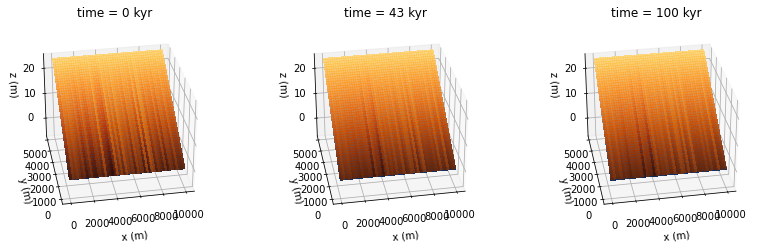

In [285]:
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LightSource
from matplotlib import cm

#cmap = cm.YlOrBr_r
#cmap = cm.gist_earth

try:
    from cmcrameri import cm
    cmap2 = cm.batlow
except:
    cmap2 = 'viridis'

alpha_top = 0.75

zmin, zmax = zg[np.isnan(zg)==False].min(), zg[np.isnan(zg)==False].max()

fig = pl.figure(figsize=(12, 10/ntg))
axs = [fig.add_subplot(1, ntg, i, projection='3d') for i in range(1, ntg+1)]

for i, ti in enumerate(output_ts):
    wt = axs[i].plot_surface(xg, yg, hg[i] - 0.01, cmap='Blues_r',
                             linewidth=0, antialiased=False, zorder=10)
    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(zg[i], cmap=cmap, vert_exag=0.1, blend_mode='soft', vmin=zmin, vmax=zmax*1.5)
    #rgb = ls.shade(zg[i], cmap=cm.gist_earth)
    
    rgb[:, :, -1][zm[i]==True] = 0.0
    
    rgb[:, :, -1] = alpha_top
    
    surf = axs[i].plot_surface(xg, yg, zg[i], facecolors=rgb,
                               linewidth=0, antialiased=False, 
                               shade=False, zorder=11)

zmin -= 0.25 * (zmax - zmin)
for ax in axs:
    ax.set_zlim(zmin, zmax)
    ax.view_init(elev=30., azim=260)

for ax, ti in zip(axs, output_ts):
    tekst = 'time = %0.0f kyr' % (times[ti] / year / 1e3)
    ax.set_title(tekst)
    ax.set_zlabel('z (m)', rotation=90)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

fig.tight_layout()
fig.subplots_adjust(wspace=-0.1)

fig.savefig('fig/3d_fig_model_results_%s.pdf' % output_file_adj)

In [286]:
5000 * ModelParams.S_init

NameError: name 'ModelParams' is not defined